Link de la data: https://www.dropbox.com/sh/3s7j40jia09t09b/AABifaGQHpQHw4mM55tW9gpja?dl=0

## Información del conjunto de datos

Hay una falta de conjuntos de datos públicos disponibles sobre servicios financieros y especialmente en el dominio emergente de transacciones de dinero móvil. Los conjuntos de datos financieros son importantes para muchos investigadores y, en particular, para nosotros que realizamos investigaciones en el ámbito de la detección de fraudes. Parte del problema es la naturaleza intrínsecamente privada de las transacciones financieras, que no lleva a conjuntos de datos disponibles públicamente.

Presentamos un conjunto de datos sintéticos generado utilizando el simulador llamado PaySim como un enfoque para tal problema. PaySim utiliza datos agregados del conjunto de datos privado para generar un conjunto de datos sintético que se asemeja al funcionamiento normal de las transacciones e inyecta un comportamiento malicioso para luego evaluar el rendimiento de los métodos de detección de fraude.

Variables de entrada :

1. steep(tipo) - EFECTIVO, EFECTIVO, DÉBITO, PAGO y TRANSFERENCIA.

2. amount(cantidad) -monto de la transacción en moneda local.

3. nameOrig: cliente que inició la transacción

4. oldbalanceOrg - saldo inicial antes de la transacción

5. newbalanceOrig - nuevo saldo después de la transacción

6. nameDest - cliente que es el destinatario de la transacción

7. oldbalanceDest: destinatario del saldo inicial antes de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).

8. newbalanceDest: nuevo destinatario del saldo después de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).


9. isFlaggedFraud: el modelo de negocio tiene como objetivo controlar transferencias masivas de una cuenta a otra y señala intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200,000 en una sola transacción.

Variable de salida:

10. isFraud: son las transacciones realizadas por los agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes apunta a obtener ganancias tomando el control de las cuentas de los clientes e intentando vaciar los fondos transfiriéndolos a otra cuenta y luego retirando del sistema.


In [2]:
import pandas as pd
bank = pd.read_csv('PS_20174392719_1491204439457_log.csv')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
bank.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [4]:
#Importamos librerías necesarias
import os
import matplotlib.pyplot as plt #Librería Gráfica
%matplotlib inline
import seaborn as sns #Librería Gráfica
import numpy as np
import pandas as pd
import model_evaluation_utils as meu
from graphviz import Source
from imblearn.combine import SMOTETomek              #Para Balanceo de Datos
from sklearn.model_selection import train_test_split #Particionamiento de Datos
from sklearn.model_selection import cross_val_score  #Para llevar a cabo cross-validation
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier      #Para hacer un modelo de A.D.
from sklearn.ensemble import RandomForestClassifier  #Para hacer un modelo de Random Forest
from sklearn.naive_bayes import GaussianNB           #Para hacer un modelo de Naive-Bayes
from sklearn.svm import SVC                          #Para hacer un modelo de SVM
from sklearn.model_selection import GridSearchCV     #Para optimización de parámetros
from sklearn.tree import export_graphviz
from sklearn.preprocessing import KBinsDiscretizer   #Para Discretización
from sklearn.preprocessing import label_binarize     #Para binarizar la variable objetivo
from sklearn.preprocessing import LabelEncoder       #Para codificar variables
from collections import defaultdict                  #Para crear diccionarios con valores por defecto

import warnings
warnings.filterwarnings("ignore")

from joblib import dump
from joblib import load

import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator #Para Redes Neuronales
from IPython.display import Image

In [5]:
bank.type

0           PAYMENT
1           PAYMENT
2          TRANSFER
3          CASH_OUT
4           PAYMENT
             ...   
6362615    CASH_OUT
6362616    TRANSFER
6362617    CASH_OUT
6362618    TRANSFER
6362619    CASH_OUT
Name: type, Length: 6362620, dtype: object

In [6]:
df_bank = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
#Extrayendo sólo variables de interés
df_bank=df_bank.drop(['step','nameOrig', 'nameDest', 'isFlaggedFraud'],axis=1)
df_bank.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [8]:
df_bank.isna().sum()

type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Dividimos los datos para el entrenamiento y testeo en una proporción de 70 y 30, respectivamente.

In [17]:
x=df_bank.iloc[:,0:df_bank.shape[1]-1].values
y=df_bank.iloc[:,df_bank.shape[1]-1].values

In [18]:
xtrain,xtest,ytrain,ytest=train_test_split(x,
                                           y,
                                           test_size=0.3,
                                           random_state=2020,
                                           stratify=y)

Aplicamos balanceo de datos under-sampling, fijando como parámetro 0.8

In [19]:
frecuencia =pd.value_counts(df_bank.isFraud,sort=True)
frecuencia

0    6354407
1       8213
Name: isFraud, dtype: int64

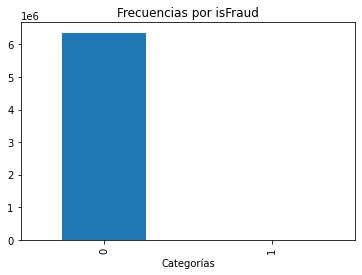

In [20]:
frecuencia.plot.bar()
plt.title('Frecuencias por isFraud')
plt.xlabel('Categorías')
plt.show()

Como los datos estan desbalanceados, se utilizará el método de UNDERSAMPLING

In [21]:
from imblearn.under_sampling import RandomUnderSampler

In [22]:
under=RandomUnderSampler(sampling_strategy=0.8,random_state=2020)
xtrain_under,ytrain_under=under.fit_resample(xtrain,ytrain)


In [23]:
columnas=df_bank.columns.to_list()
target=columnas[6]
xnames=[v for v in columnas if v not in target]

In [24]:
xtrain_underdf=pd.DataFrame(xtrain_under,columns=xnames)
ytrain_underdf=pd.DataFrame(ytrain_under,columns=[target])
bank_underdf=pd.concat([xtrain_underdf,ytrain_underdf],axis=1)
bank_underdf.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,DEBIT,758.37,0.0,0.0,1300565.12,1301323.49,0
1,CASH_OUT,111367.66,0.0,0.0,2320500.36,2431868.02,0
2,PAYMENT,22786.2,520571.85,497785.65,0.0,0.0,0
3,CASH_OUT,39833.66,0.0,0.0,3961106.68,4000940.34,0
4,PAYMENT,7246.3,9693.25,2446.95,0.0,0.0,0


In [25]:
frec_UNDER=pd.value_counts(bank_underdf.isFraud,sort=True)
frec_UNDER

0    7186
1    5749
Name: isFraud, dtype: int64

Implemetamos el modelo de árboles de decisión a los datos de entrenamiento

In [26]:
df_bank.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [27]:
len(df_bank)

6362620

In [28]:
#Calculando frecuencias para la variable Type
pd.value_counts(df_bank.type)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [29]:
#Calculando frecuencias para la variable target
pd.value_counts(df_bank.isFraud)

0    6354407
1       8213
Name: isFraud, dtype: int64

In [30]:
df_bank["CASH_OUT"]=np.where(df_bank["type"]=="CASH_OUT",1,0)
df_bank["PAYMENT"]=np.where(df_bank["type"]=="PAYMENT",1,0)
df_bank["CASH_IN"]=np.where(df_bank["type"]=="CASH_IN",1,0)
df_bank["TRANSFER"]=np.where(df_bank["type"]=="TRANSFER",1,0)
df_bank["DEBIT"]=np.where(df_bank["type"]=="DEBIT",1,0)

In [31]:
df_bank.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,PAYMENT,CASH_IN,TRANSFER,DEBIT
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1,0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0,0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0


In [32]:
#Nos quedamos sólo con los validos
validos=["CASH_OUT","PAYMENT","CASH_IN","TRANSFER","DEBIT","amount","oldbalanceOrg","newbalanceOrig",
         "oldbalanceDest","newbalanceDest","isFraud"]
df_bank=df_bank[validos]

In [33]:
df_bank.head()

,CASH_OUT,PAYMENT,CASH_IN,TRANSFER,DEBIT,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,1,0,0,0,9839.64,170136.0,160296.36,0.0,0.0,0
1,0,1,0,0,0,1864.28,21249.0,19384.72,0.0,0.0,0
2,0,0,0,1,0,181.00,181.0,0.00,0.0,0.0,1
3,1,0,0,0,0,181.00,181.0,0.00,21182.0,0.0,1
4,0,1,0,0,0,11668.14,41554.0,29885.86,0.0,0.0,0


In [34]:
predictores=["CASH_OUT","PAYMENT","CASH_IN","TRANSFER","DEBIT","amount","oldbalanceOrg","newbalanceOrig",
             "oldbalanceDest","newbalanceDest"]

In [35]:
target

'isFraud'

In [36]:
#Identificando nuestra matriz de datos X y variable target y
x=df_bank.loc[:,predictores].values
y=df_bank.loc[:,target].values

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2020)

In [37]:
#Instanciamos un objeto de clase DecisionTreeClasifier
tree_proc=DecisionTreeClassifier(max_depth=4) #(Por default trabaja con GINI)
tree_proc

DecisionTreeClassifier(max_depth=4)

In [38]:
#Hacer que aprenda de los datos de entrenamiento
tree_proc=tree_proc.fit(X_train,y_train)

In [39]:
#Mostrando la Importancia de las Características o Variables Predictoras
importances= tree_proc.feature_importances_
importances

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.18742717e-03,
       0.00000000e+00, 7.74088818e-02, 3.18869086e-01, 2.17013276e-04,
       1.39690743e-01, 4.60626849e-01])

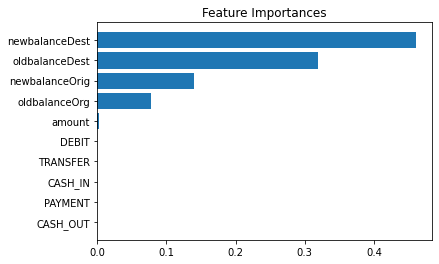

In [40]:
importances= tree_proc.feature_importances_
indices=np.argsort(importances)
p=X_train.shape[1]

plt.figure()
plt.title("Feature Importances")
plt.barh(range(p),importances[indices])
plt.yticks(range(p),predictores)
plt.show()

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn import tree

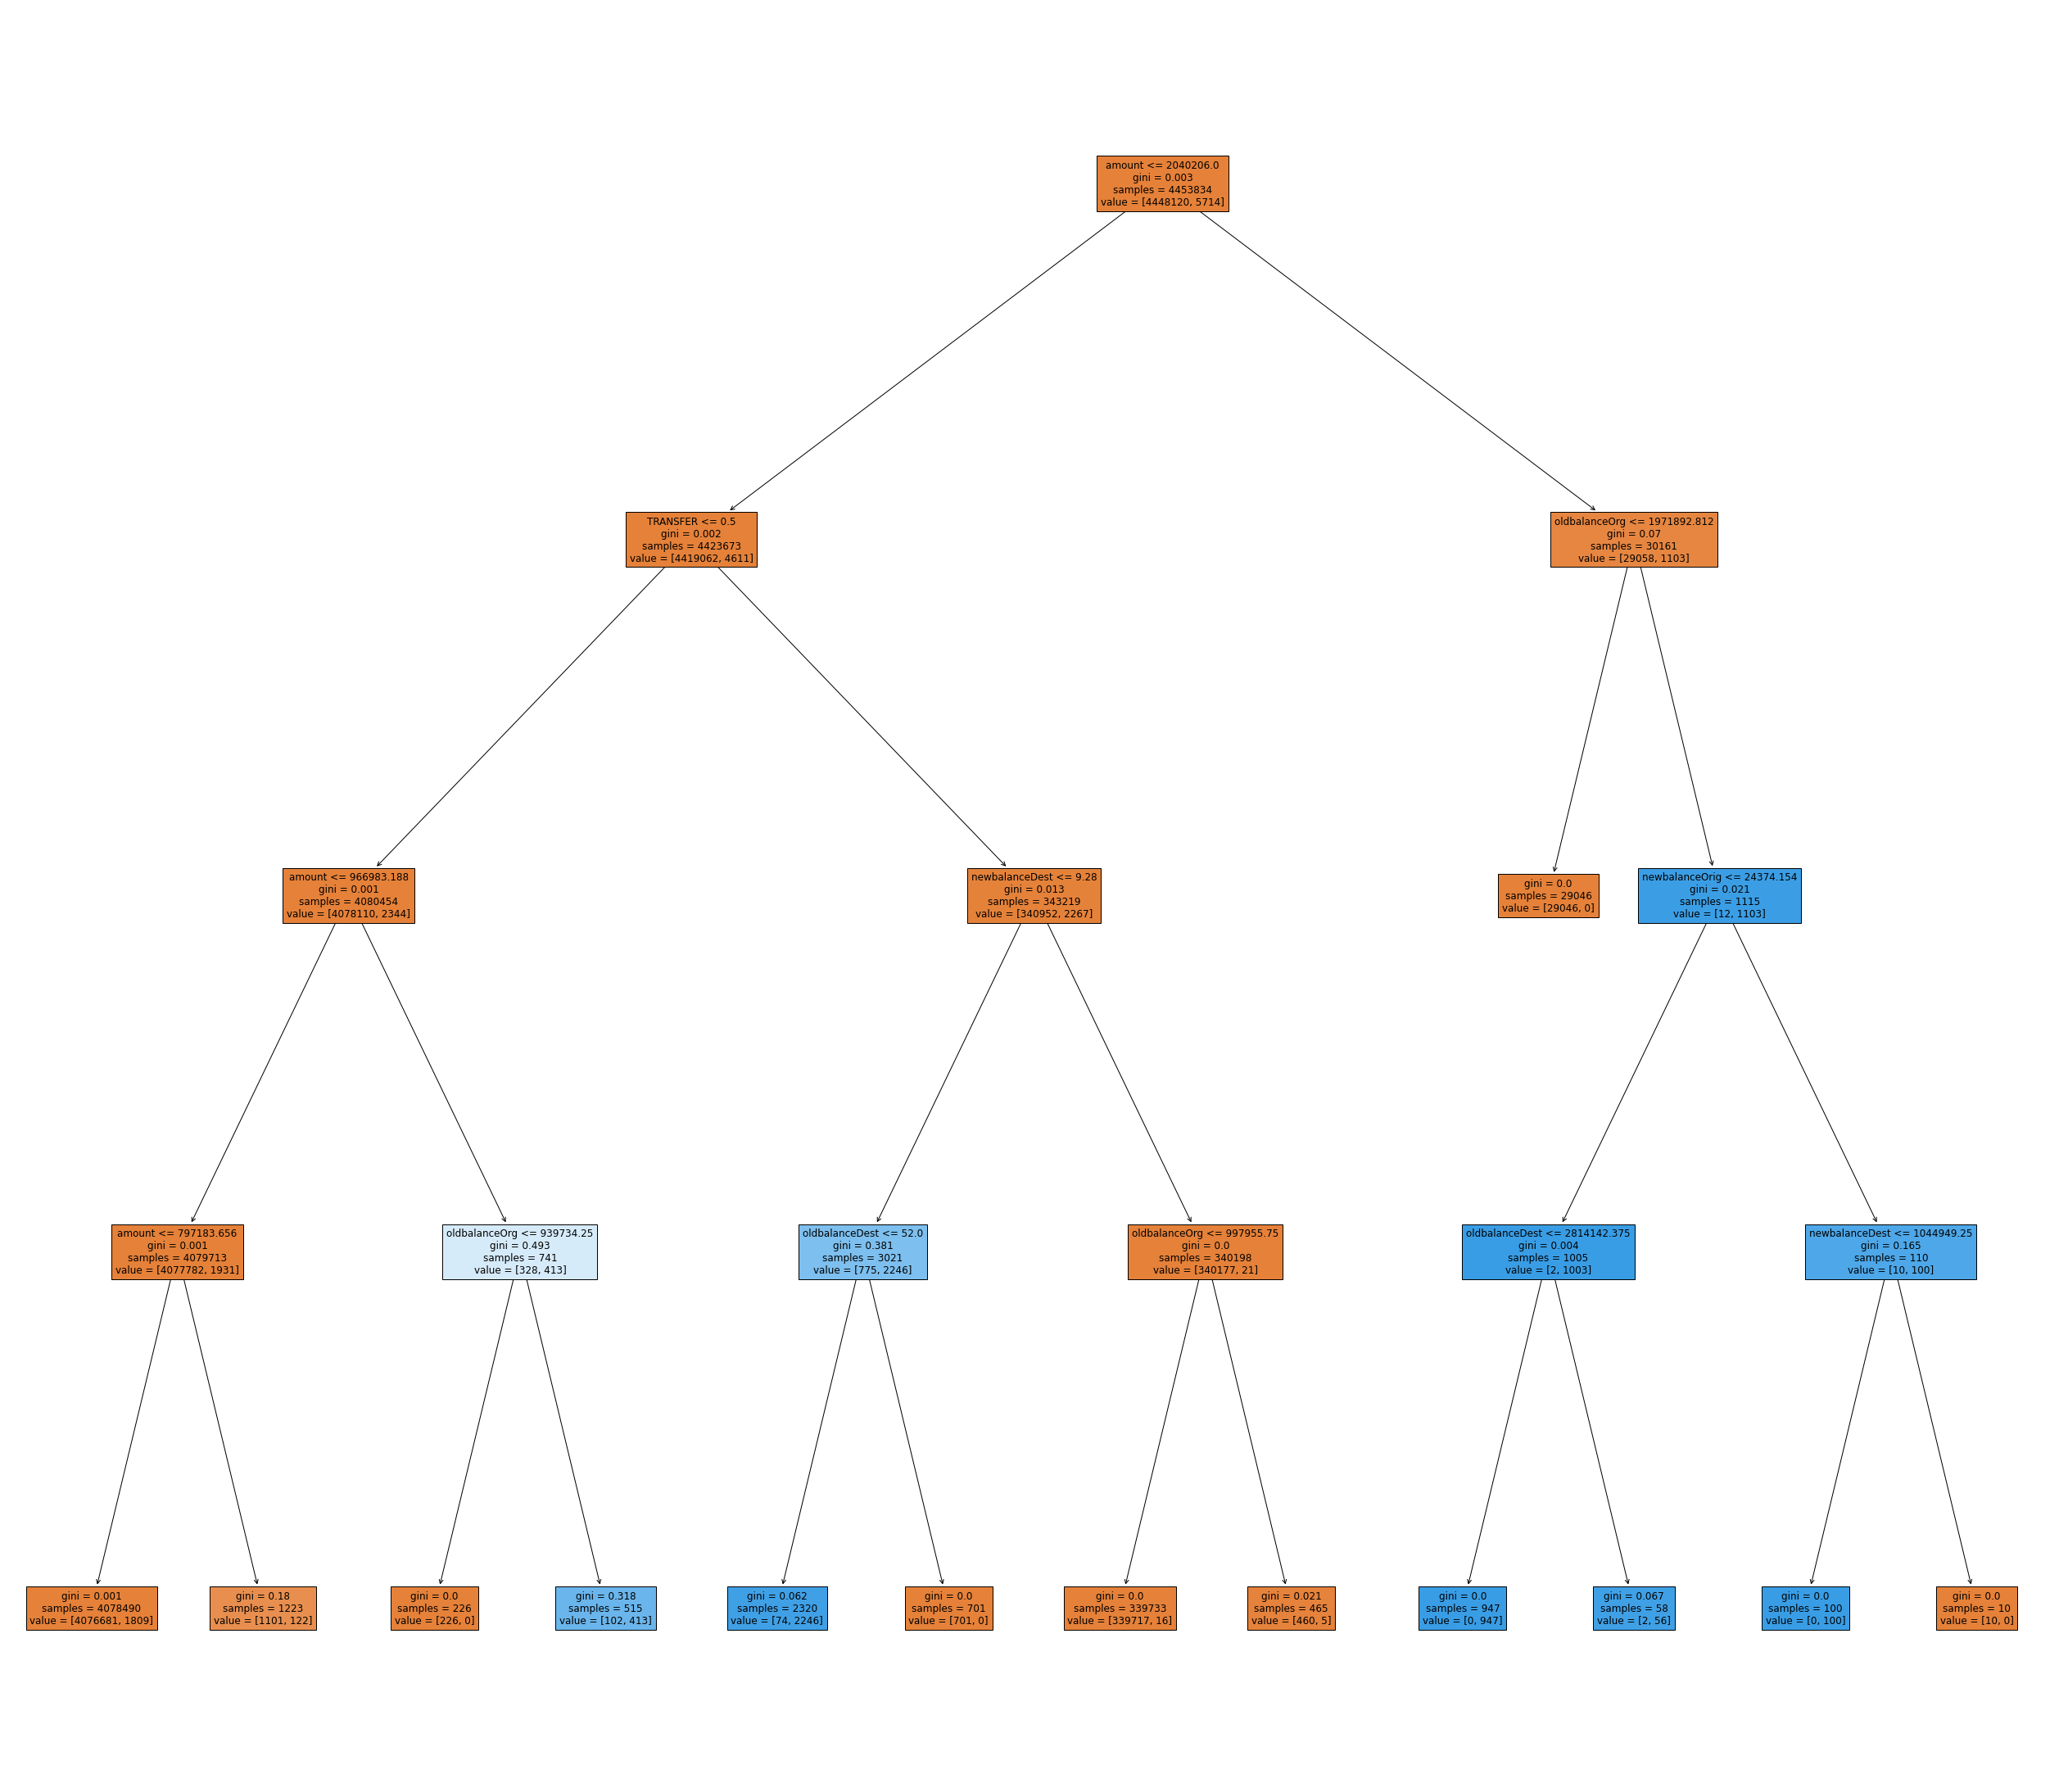

In [42]:
#Establecemos un tamaño grande visualmente hablando
fig=plt.figure(figsize=(45,40))
#Ploteamos el árbol de decisión
_=plot_tree(decision_tree= tree_proc, feature_names=predictores,filled=True)

In [43]:
text_representation= tree.export_text(decision_tree=tree_proc,feature_names=predictores)
print(text_representation)

|--- amount <= 2040206.00
|   |--- TRANSFER <= 0.50
|   |   |--- amount <= 966983.19
|   |   |   |--- amount <= 797183.66
|   |   |   |   |--- class: 0
|   |   |   |--- amount >  797183.66
|   |   |   |   |--- class: 0
|   |   |--- amount >  966983.19
|   |   |   |--- oldbalanceOrg <= 939734.25
|   |   |   |   |--- class: 0
|   |   |   |--- oldbalanceOrg >  939734.25
|   |   |   |   |--- class: 1
|   |--- TRANSFER >  0.50
|   |   |--- newbalanceDest <= 9.28
|   |   |   |--- oldbalanceDest <= 52.00
|   |   |   |   |--- class: 1
|   |   |   |--- oldbalanceDest >  52.00
|   |   |   |   |--- class: 0
|   |   |--- newbalanceDest >  9.28
|   |   |   |--- oldbalanceOrg <= 997955.75
|   |   |   |   |--- class: 0
|   |   |   |--- oldbalanceOrg >  997955.75
|   |   |   |   |--- class: 0
|--- amount >  2040206.00
|   |--- oldbalanceOrg <= 1971892.81
|   |   |--- class: 0
|   |--- oldbalanceOrg >  1971892.81
|   |   |--- newbalanceOrig <= 24374.15
|   |   |   |--- oldbalanceDest <= 2814142.38
|   

In [44]:
predictores=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","amount","TRANSFER"]
target=['isFraud']

In [45]:
x=df_bank.loc[:,predictores].values
y=df_bank.loc[:,target].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=2020)

In [47]:
#Undersampling
us=RandomUnderSampler(sampling_strategy=0.8,random_state=2020)
X_train_bal_u,y_train_bal_u=us.fit_resample(X_train,y_train)

In [48]:
#Creando una nueva instancia de DecisionTreeClassifier
tree_proc2=DecisionTreeClassifier(max_depth=4)
tree_proc2

DecisionTreeClassifier(max_depth=4)

In [49]:
tree_proc2=tree_proc2.fit(X_train_bal_u,y_train_bal_u)

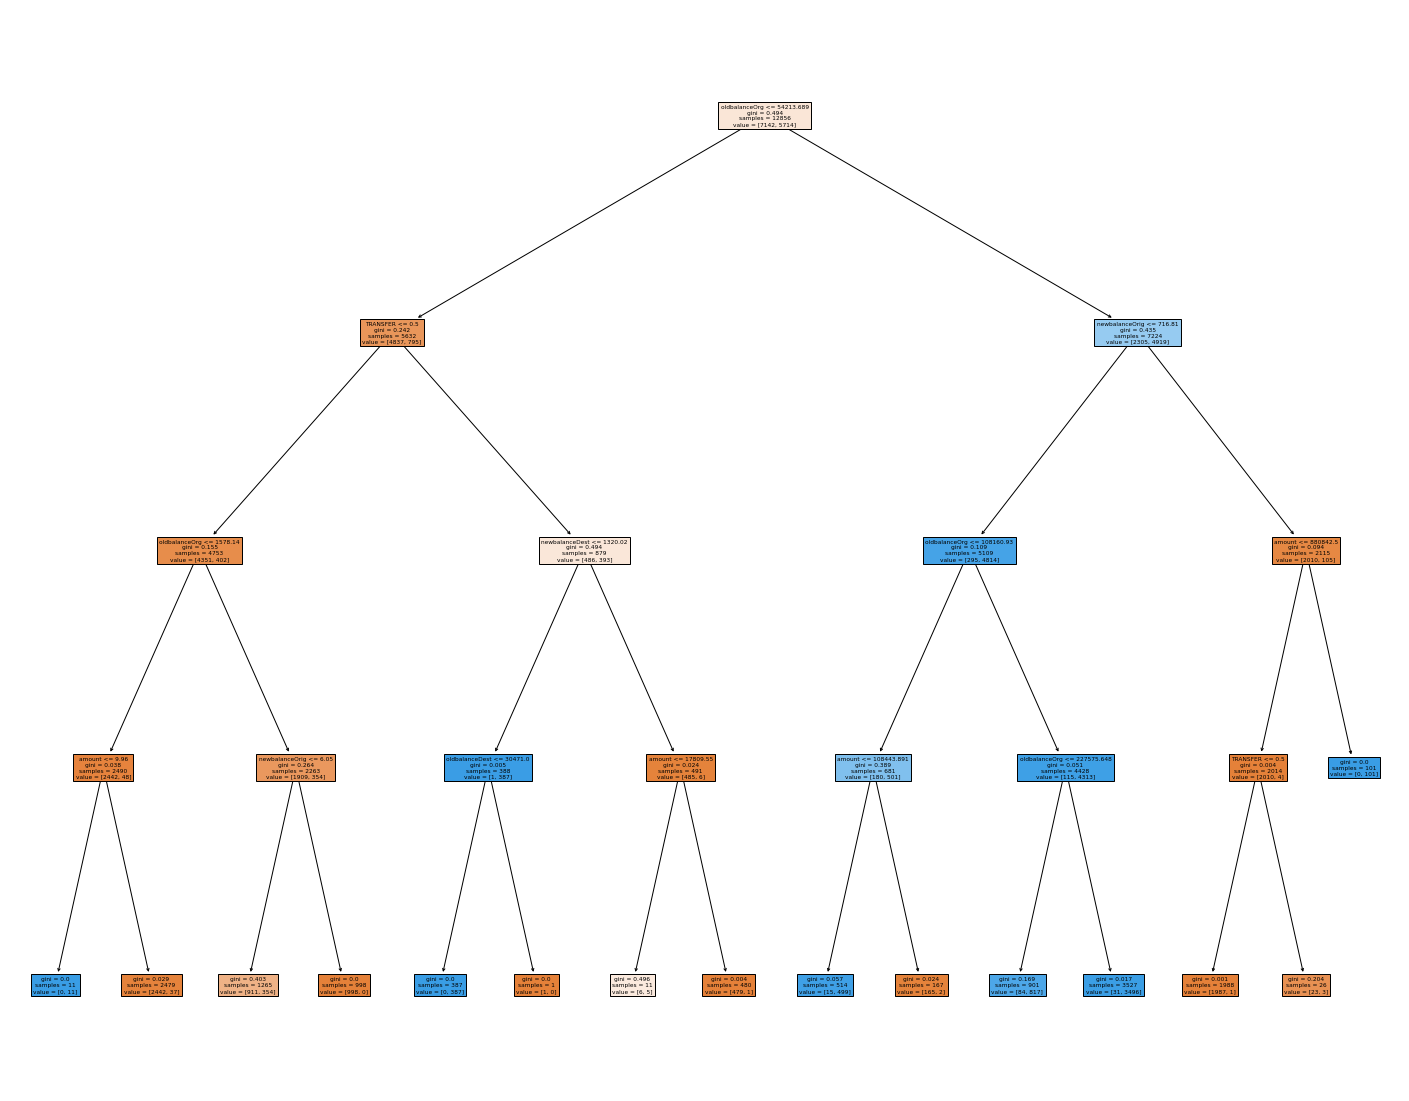

In [50]:
#Establecemos un tamaño grande visualmente hablando
fig=plt.figure(figsize=(25,20))
#Ploteamos el árbol de decisión
_=plot_tree(decision_tree= tree_proc2, feature_names=predictores,filled=True)

In [51]:
text_representation= tree.export_text(decision_tree=tree_proc2,feature_names=predictores)
print(text_representation)

|--- oldbalanceOrg <= 54213.69
|   |--- TRANSFER <= 0.50
|   |   |--- oldbalanceOrg <= 1578.14
|   |   |   |--- amount <= 9.96
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  9.96
|   |   |   |   |--- class: 0
|   |   |--- oldbalanceOrg >  1578.14
|   |   |   |--- newbalanceOrig <= 6.05
|   |   |   |   |--- class: 0
|   |   |   |--- newbalanceOrig >  6.05
|   |   |   |   |--- class: 0
|   |--- TRANSFER >  0.50
|   |   |--- newbalanceDest <= 1320.02
|   |   |   |--- oldbalanceDest <= 30471.00
|   |   |   |   |--- class: 1
|   |   |   |--- oldbalanceDest >  30471.00
|   |   |   |   |--- class: 0
|   |   |--- newbalanceDest >  1320.02
|   |   |   |--- amount <= 17809.55
|   |   |   |   |--- class: 0
|   |   |   |--- amount >  17809.55
|   |   |   |   |--- class: 0
|--- oldbalanceOrg >  54213.69
|   |--- newbalanceOrig <= 716.81
|   |   |--- oldbalanceOrg <= 108160.93
|   |   |   |--- amount <= 108443.89
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  108443.89
|   |   | 

In [52]:
#Validacion del modelo


In [53]:
#Accuracy: Para Datos de Entrenamiento
tree_proc2.score(X_train_bal_u,y_train_bal_u)

0.9585407591785936

In [54]:
#Accuracy: Para Datos de Testeo
tree_proc2.score(X_test,y_test)

0.9801334460751493

In [51]:
#La probabilidad de pertenecer a la clase
probs = clf.predict_proba(x_p)
probs

array([[0.98537253, 0.01462747],
       [0.80959355, 0.19040645],
       [0.8116856 , 0.1883144 ],
       ...,
       [0.81328788, 0.18671212],
       [0.84558474, 0.15441526],
       [0.81040798, 0.18959202]])